# Working with MPAS Meshes


This example provides an overview of MPAS meshes and the dataset we will use in this notebook, shows how UXarray can be used to explore MPAS grids, and gives a number of 
analysis and visualization functions that can be useful on MPAS data.

##  MPAS Mesh Overview

All components of MPAS lie on a C-grid staggered Voronoi Mesh as seen in the figure below:

<p align="center">
  <img src="../_static/examples/mpas/c-grid.png"
  width="400" / >
</p>

This type of mesh is represented through two different sub-meshes. The Primal Mesh represents the Voronoi Mesh and the Dual Mesh represents the Triangular Mesh.





## Dataset Overview

As mentioned in earlier notebooks, the grid definition and data variables are typically stored in separate files. However, in this example, our dataset will contain both in the same file, which is often the case when working with smaller datasets. With this in mind, we will be working exclusively with `Grid` objects to investigate the grid topology and not with `UxDataset` or `UxDataArray` objects.

However, before we move on to the exploration of the MPAS grid with **UXarray** features, let us have a quick look into the dataset, openning it with **Xarray**:

In [1]:
# Data paths
mpas_root_filepath = "../../test/meshfiles/mpas/"
mpas_dataset_filepath = mpas_root_filepath + "QU/mesh.QU.1920km.151026.nc"

In [2]:
import xarray as xr

xrds_mpas = xr.open_dataset(mpas_dataset_filepath)
xrds_mpas

<xarray.Dataset>
Dimensions:               (nCells: 162, nEdges: 480, nVertices: 320,
                           maxEdges: 6, maxEdges2: 12, TWO: 2, vertexDegree: 3)
Dimensions without coordinates: nCells, nEdges, nVertices, maxEdges, maxEdges2,
                                TWO, vertexDegree
Data variables: (12/42)
    latCell               (nCells) float64 ...
    lonCell               (nCells) float64 ...
    xCell                 (nCells) float64 ...
    yCell                 (nCells) float64 ...
    zCell                 (nCells) float64 ...
    indexToCellID         (nCells) int32 ...
    ...                    ...
    cellQuality           (nCells) float64 ...
    gridSpacing           (nCells) float64 ...
    triangleQuality       (nVertices) float64 ...
    triangleAngleQuality  (nVertices) float64 ...
    obtuseTriangle        (nVertices) int32 ...
    meshDensity           (nCells) float64 ...
Attributes:
    on_a_sphere:    YES
    sphere_radius:  1.0
    is_periodic:    NO
    history:        MpasMeshConverter.x base_grids/x1.162.grid.nc base_meshes...
    mesh_spec:      1.0
    Conventions:    MPAS
    source:         MpasMeshConverter.x
    file_id:        rku96q0z66

Here we opened up the dataset to get an overview of the full set of connectivity variables needed to describe an MPAS mesh as described in the MPAS Specification Document [2]. Below is a list of connectivity variables and their geometric meaning, which will be further described when comparing to the UGRID encoding:

### Primal Mesh
* **lonVertex, latVertex**: Corner Vertices of Primal Mesh cells
* **lonCell, latCell**: Center Vertices of Primal Mesh cells
* **verticesOnCell**: Vertex indices that surround each Primal Mesh cell
* **verticesOnEdge**: Vertex indices that saddle a given edge
* **nEdgesOnCell**: Maximum number of edges that can surround a cell

### Dual Mesh
* **lonCell, latCell**: Corner Vertices of Dual Mesh cells
* **lonVertex, latVertex**: Center Vertices of Dual Mesh cells
* **cellsOnVertex**: Vertex indices that surround each Dual Mesh cell
* **cellsOnEdge**: Vertex indices that saddle a given edge


## Constructing a Grid Object

The `xarray.Dataset` that we opened above stores the coordinates and connectivity variables according to the MPAS specification standards for both the Primal and Dual meshes together in a single dataset. Here, instead of opening up the dataset using Xarray, we can pass through the path into our `open_grid` method to construct a `Grid` object. This `Grid` can be constructed for either the Primal or Dual meshes by parsing and encoding the appropriate variables in the UGRID conventions.

In [3]:
import uxarray as ux

primal_mesh = ux.open_grid(mpas_dataset_filepath, use_dual=False)
dual_mesh = ux.open_grid(mpas_dataset_filepath, use_dual=True)

In [4]:
primal_mesh

<uxarray.Grid>
Original Grid Type: mpas
Grid Dimensions:
  * nMesh2_node: 320
  * nMesh2_face: 162
  * nMaxMesh2_face_nodes: 6
  * nMesh2_edge: 480
Grid Coordinate Variables:
  * Mesh2_node_x: (320,)
  * Mesh2_node_y: (320,)
  * Mesh2_face_x: (162,)
  * Mesh2_face_y: (162,)
Grid Connectivity Variables:
  * Mesh2_face_nodes: (162, 6)
  * Mesh2_edge_nodes: (480, 2)
  * nNodes_per_face: (162,)

In [5]:
dual_mesh

<uxarray.Grid>
Original Grid Type: mpas
Grid Dimensions:
  * nMesh2_node: 162
  * nMesh2_face: 320
  * nMaxMesh2_face_nodes: 3
  * nMesh2_edge: 480
Grid Coordinate Variables:
  * Mesh2_node_x: (162,)
  * Mesh2_node_y: (162,)
  * Mesh2_face_x: (320,)
  * Mesh2_face_y: (320,)
Grid Connectivity Variables:
  * Mesh2_face_nodes: (320, 3)
  * Mesh2_edge_nodes: (480, 2)
  * nNodes_per_face: (320,)

## Relationship between MPAS and UGRID

In the **Dataset Overview** section, we outlined the key grid variables that were parsed and used for encoding our `Grid` in the **UGRID** conventions. Below is an overview of how we derived the coordinate and connectivity variables and how they are internally represented.


### Grid Variables (Primal Mesh)
`Mesh2_node_x` & `Mesh2_node_y`
* Longitude and Latitude coordinates of the Primal Mesh corner nodes
* Derived from `lonVertex` & `latVertex`
* Converted from Radians to Degrees

`Mesh2_face_x` & `Mesh2_face_y`
* Longitude and Latitude coordinates of the Primal Mesh center nodes
* Derived from `lonCell` & `latCell`
* Converted from Radians to Degrees

`Mesh2_face_nodes`
* Connectivity array describing which nodes make up a face
* Derived from `verticesOnCell`
* Padding is replaced with `INT_FILL_VALUE`
* Missing Values (zeros) replaced with `INT_FILL_VALUE`
* Converted to zero-index

`Mesh2_edge_nodes`
* Connectivity array describing which nodes link to form each edge
* Derived from `verticesOnEdge`
* Padding is replaced with `INT_FILL_VALUE`
* Missing Values (zeros) replaced with `INT_FILL_VALUE`
* Converted to zero-index

### Grid Variables (Dual Mesh)

`Mesh2_node_x` & `Mesh2_node_y`
* Longitude and Latitude coordinates of the Dual Mesh vertices
* Derived from `lonCell` & `latCell`, the centers of the Primal Mesh
* Converted from Radians to Degrees

`Mesh2_face_x` & `Mesh2_face_y`
* Longitude and Latitude coordinates of the Dual Mesh centers
* Derived from `lonVertex` & `latVertex`, the vertices of the Primal Mesh
* Converted from Radians to Degrees

`Mesh2_face_nodes`
* Connectivity array describing which nodes make up a face
* Derived from `verticesOnCell`
* Padding is replaced with `INT_FILL_VALUE`
* Missing Values (zeros) replaced with `INT_FILL_VALUE`
* Converted to zero-index

`Mesh2_edge_nodes`
* Connectivity array describing which nodes link to form each edge
* Derived from `verticesOnEdge`
* Padding is replaced with `INT_FILL_VALUE`
* Missing Values (zeros) replaced with `INT_FILL_VALUE`
* Converted to zero-index

### Face Area

Since our mesh lies on a sphere, the expected total face area is the following:

$$
4\pi r^{2}
$$

Using our parsed attributes, we can access the `sphere_radius` to calculated the expected face area.

In [6]:
import numpy as np

sphere_r = primal_mesh.parsed_attrs['sphere_radius']
expected_area = 4 * np.pi * (sphere_r)**2
expected_area

12.566370614359172

The individual and total face areas of our Primal Mesh can be calculated, cached, and accessed as follows

In [7]:
primal_mesh_face_areas = primal_mesh.face_areas
primal_mesh_face_areas.sum()

12.5663761450242

We can then compute the absolute error of our calculation

In [8]:
abs(expected_area - primal_mesh_face_areas.sum())

5.530665028175008e-06

We can do the same for the Dual Mesh

In [9]:
dual_mesh_face_areas = dual_mesh.face_areas
dual_mesh_face_areas.sum()

12.566372994960695

In [10]:
abs(expected_area - dual_mesh_face_areas.sum())

2.3806015221339294e-06

We can see that the total face area of both the Primal and Dual meshes is within 1e-6 of the expected area. For a more detailed explanation of the face area calculation and ways to obtain more precision, check out our other notebooks.

## Visualization

To visually confirm that the Primal and Dual meshes have been converted properly, the following showcases a basic visualization of the mesh structure.

To display the mesh, the vertices are used to construct a `PolyCollection` object, which represents a group of polygons on a plane. The collection is then fed into Matplotlib to be visualized.


```{note}
The following visualizations showcase the mesh structure excluding any faces that are located on the boundary between 0 and 360 degrees. There is work currently being done to handle these cases and to provide a more sophisticated visualization API in UXarray. Stay tuned!
```

In [12]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

from uxarray.utils.helpers import close_face_nodes

### Helper Functions

In order to make our data compatible wth the `PolyCollection` class, we need to first convert it into an appropriate representation. The following helper function takes in a `Grid` object (either Primal or Dual mesh) and returns the vertices of each face that can be interpreted by the `PolyCollection`.

In [13]:
def get_verts(grid):
    nodes_per_face = grid.nNodes_per_face.values
    x = grid.Mesh2_node_x.values
    y = grid.Mesh2_node_y.values
    closed_face_nodes = close_face_nodes(grid.Mesh2_face_nodes.values,
                                         grid.nMesh2_face,
                                         grid.nMaxMesh2_face_nodes)

    verts = []
    for face_node, n_nodes in zip(closed_face_nodes, nodes_per_face):
        polygon_x = x[face_node[0:n_nodes]]
        polygon_y = y[face_node[0:n_nodes]]

        # exclude faces near the boundary
        if np.any(np.abs(polygon_x - 180) > 170):
            continue

        vert = np.array([polygon_x, polygon_y])
        verts.append(vert.T)

    return verts

### Primal Mesh

The following displays the Primal Mesh, which is composed of polygons that represent Voronoi regions.

Text(0.5, 1.0, 'Primal Mesh')

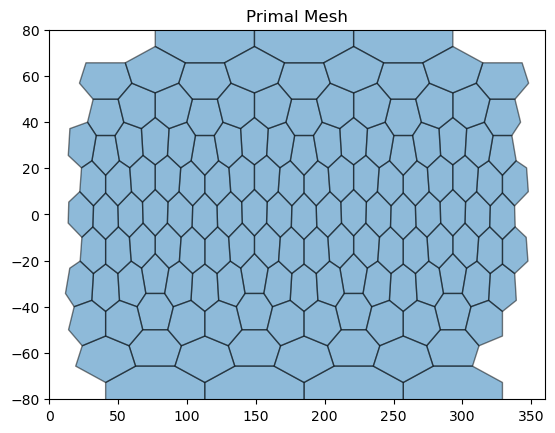

In [14]:
primal_vertices = get_verts(primal_mesh)
primal_polygons = PolyCollection(primal_vertices, edgecolors='Black', alpha=0.5)

fig, ax = plt.subplots()
ax.add_collection(primal_polygons, autolim=False)
ax.set_xlim(0, 360)
ax.set_ylim(-80, 80)
ax.set_title("Primal Mesh")

### Dual Mesh

The follwing displays the Dual Mesh, which is composed entirely of Delaunay triangles.

Text(0.5, 1.0, 'Dual Mesh')

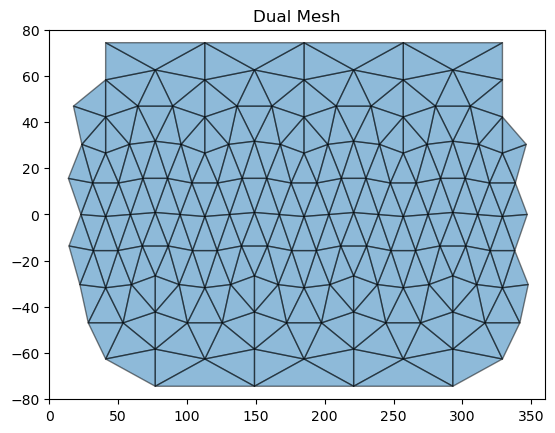

In [15]:
dual_vertices = get_verts(dual_mesh)
dual_polygons = PolyCollection(dual_vertices, edgecolors='Black', alpha=0.5)

fig, ax = plt.subplots()
ax.add_collection(dual_polygons, autolim=False)
ax.set_xlim(0, 360)
ax.set_ylim(-80, 80)
ax.set_title("Dual Mesh")

## Primal and Dual

As mentioned earlier, the Primal and Dual meshes are related to one another. The vertices of the Primal mesh are each at the center of a Delaunay triangle in the Dual mesh. Likewise, the vertices of the Dual mesh are each at the center of a Voronoi region in the Primal mesh. This relationship can be seen in the visualization below.

Text(0.5, 1.0, 'Dual & Primal Mesh')

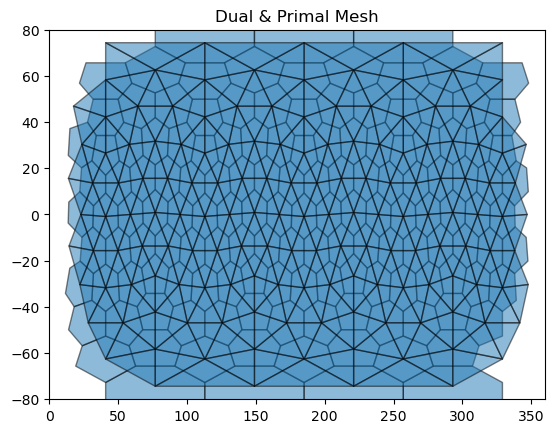

In [16]:
dual_vertices = get_verts(dual_mesh)
dual_polygons = PolyCollection(dual_vertices, edgecolors='Black', alpha=0.5)
primal_vertices = get_verts(primal_mesh)
primal_polygons = PolyCollection(primal_vertices, edgecolors='Black', alpha=0.5)

fig, ax = plt.subplots()
ax.add_collection(primal_polygons, autolim=False)
ax.add_collection(dual_polygons, autolim=False)
ax.set_xlim(0, 360)
ax.set_ylim(-80, 80)
ax.set_title("Dual & Primal Mesh")

## References

[1] https://mpas-dev.github.io/

[2] https://mpas-dev.github.io/files/documents/MPAS-MeshSpec.pdf

[3] http://ugrid-conventions.github.io/ugrid-conventions/